In [24]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

In [25]:
# Load the dataset
file_path = "/content/prediction_data.xlsx"
xls = pd.ExcelFile(file_path)
data = pd.read_excel(xls, sheet_name="vw_ChurnData")

In [26]:
# Drop unnecessary columns (like customer ID)
data.drop(columns=["CUSTOMER_ID"], inplace=True)

In [27]:

# Handling missing values
data.fillna(method='ffill', inplace=True)

/tmp/ipython-input-27-70399754.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [28]:
# Encoding categorical variables
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    if col != 'Customer_Status':  # Skip target column
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

In [29]:
# Define features and target
X = data.drop(columns=["Customer_Status"])
y = data["Customer_Status"].apply(lambda x: 1 if x == "Churned" else 0)

In [30]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [33]:
y_pred = model.predict(X_test)


In [34]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.956738768718802
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       847
           1       1.00      0.85      0.92       355

    accuracy                           0.96      1202
   macro avg       0.97      0.93      0.95      1202
weighted avg       0.96      0.96      0.96      1202



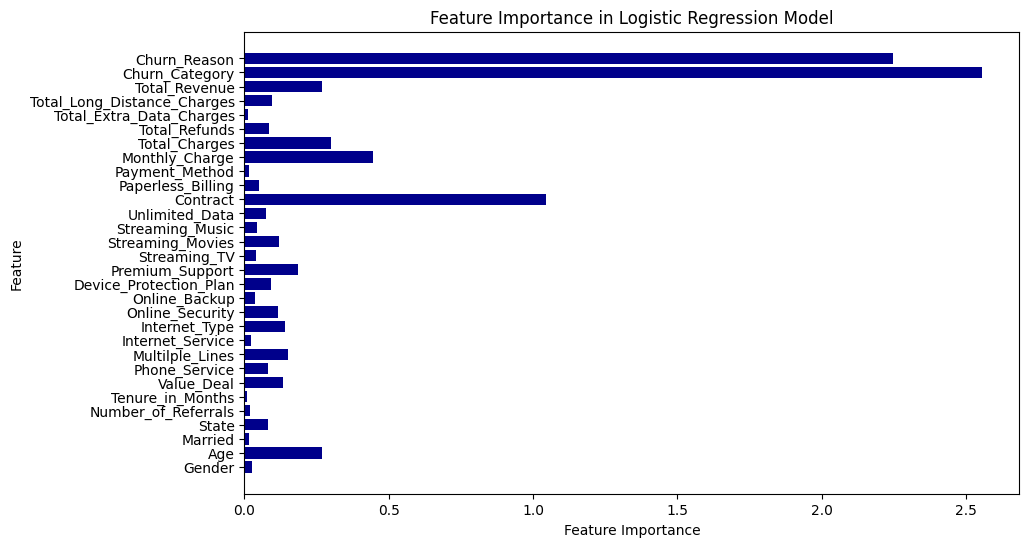

In [35]:
# Plot feature importances
feature_importance = abs(model.coef_[0])
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color = 'darkblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression Model")
plt.show()


In [36]:
# Load vw_JoinData sheet for prediction
join_data = pd.read_excel(xls, sheet_name="vw_JoinData")
join_data.drop(columns=["CUSTOMER_ID", "Customer_Status"], errors='ignore', inplace=True)
join_data.fillna(method='ffill', inplace=True)

/tmp/ipython-input-36-310845689.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  join_data.fillna(method='ffill', inplace=True)


In [37]:
# Encode categorical variables for vw_JoinData
for col in join_data.select_dtypes(include=['object']).columns:
    if col in label_encoders:
        join_data[col] = join_data[col].map(lambda x: label_encoders[col].classes_.tolist().index(x) if x in label_encoders[col].classes_ else -1)
    else:
        join_data[col] = -1  # Assign -1 for completely unseen categories

In [38]:

# Scale features
join_data = scaler.transform(join_data)

# Predict churn for vw_JoinData
join_predictions = model.predict(join_data)

In [39]:

# Add predictions to dataframe
join_data_predictions = pd.read_excel(xls, sheet_name="vw_JoinData")
join_data_predictions["Churn_Prediction"] = join_predictions

# Save predictions
join_data_predictions.to_csv("join_data_predictions.csv", index=False)
print("Predictions saved to join_data_predictions.csv")

Predictions saved to join_data_predictions.csv
